In [1]:
import os
import random
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

In [2]:
class PairedImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_files = os.listdir(root_dir)
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        img = Image.open(img_path).convert("RGB")

        w, h = img.size

        # For edges2shoes: LEFT = edge, RIGHT = real image
        input_img = img.crop((0, 0, w//2, h))      # edge map
        target_img = img.crop((w//2, 0, w, h))     # real photo

        if self.transform:
            input_img = self.transform(input_img)
            target_img = self.transform(target_img)

        return input_img, target_img

In [3]:
# Download edges2shoes dataset (official pix2pix dataset)
!wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/edges2shoes.tar.gz
!tar -xzf edges2shoes.tar.gz


--2026-02-21 04:02:18--  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/edges2shoes.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2165283376 (2.0G) [application/x-gzip]
Saving to: ‘edges2shoes.tar.gz’

edges2shoes.tar.gz  100%[===================>]   2.02G   365KB/s    in 65m 21s 

2026-02-21 05:07:40 (539 KB/s) - ‘edges2shoes.tar.gz’ saved [2165283376/2165283376]



In [4]:
import torch
from torch.utils.data import DataLoader
import os

# The dataset typically extracts into 'train' and 'val' folders
base_dir = "/content/edges2shoes"
if not os.path.exists(base_dir):
    print("Error: Dataset directory not found. Please ensure the extraction in the previous cell finished.")
else:
    print("Available directories:", os.listdir(base_dir))

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dir = os.path.join(base_dir, "train")
# Pix2pix datasets usually name the test folder 'val'
test_dir  = os.path.join(base_dir, "val") if os.path.exists(os.path.join(base_dir, "val")) else os.path.join(base_dir, "test")

train_dataset = PairedImageDataset(train_dir, transform=transform)
test_dataset  = PairedImageDataset(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)

print("Train samples:", len(train_dataset))
print("Test samples:", len(test_dataset))

Available directories: ['train', 'val']
Train samples: 49825
Test samples: 200


In [5]:
class UNetBlock(nn.Module):
    def __init__(self, in_c, out_c, down=True, use_dropout=False):
        super().__init__()
        if down:
            self.block = nn.Sequential(
                nn.Conv2d(in_c, out_c, 4, 2, 1, bias=False),
                nn.BatchNorm2d(out_c),
                nn.LeakyReLU(0.2, inplace=True)
            )
        else:
            self.block = nn.Sequential(
                nn.ConvTranspose2d(in_c, out_c, 4, 2, 1, bias=False),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True)
            )
        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.block(x)
        if self.use_dropout:
            x = self.dropout(x)
        return x


In [6]:
class UNetGenerator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()

        self.down1 = nn.Conv2d(in_channels, 64, 4, 2, 1)  # no batchnorm
        self.down2 = UNetBlock(64, 128, down=True)
        self.down3 = UNetBlock(128, 256, down=True)
        self.down4 = UNetBlock(256, 512, down=True)
        self.down5 = UNetBlock(512, 512, down=True)
        self.down6 = UNetBlock(512, 512, down=True)
        self.down7 = UNetBlock(512, 512, down=True)

        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 512, 4, 2, 1),
            nn.ReLU()
        )

        self.up1 = UNetBlock(512, 512, down=False, use_dropout=True)
        self.up2 = UNetBlock(1024, 512, down=False, use_dropout=True)
        self.up3 = UNetBlock(1024, 512, down=False, use_dropout=True)
        self.up4 = UNetBlock(1024, 512, down=False)
        self.up5 = UNetBlock(1024, 256, down=False)
        self.up6 = UNetBlock(512, 128, down=False)
        self.up7 = UNetBlock(256, 64, down=False)

        self.final = nn.Sequential(
            nn.ConvTranspose2d(128, out_channels, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)

        bottleneck = self.bottleneck(d7)

        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1, d7], 1))
        up3 = self.up3(torch.cat([up2, d6], 1))
        up4 = self.up4(torch.cat([up3, d5], 1))
        up5 = self.up5(torch.cat([up4, d4], 1))
        up6 = self.up6(torch.cat([up5, d3], 1))
        up7 = self.up7(torch.cat([up6, d2], 1))

        return self.final(torch.cat([up7, d1], 1))


In [7]:
class PatchDiscriminator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        def block(in_c, out_c, stride=2):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 4, stride, 1, bias=False),
                nn.BatchNorm2d(out_c),
                nn.LeakyReLU(0.2, inplace=True)
            )

        self.model = nn.Sequential(
            nn.Conv2d(in_channels*2, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),

            block(64, 128),
            block(128, 256),
            block(256, 512, stride=1),

            nn.Conv2d(512, 1, 4, 1, 1)  # Patch output
        )

    def forward(self, x, y):
        return self.model(torch.cat([x, y], dim=1))


In [8]:
class BaselineCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1), nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

G = UNetGenerator().to(device)
D = PatchDiscriminator().to(device)
baseline = BaselineCNN().to(device)

criterion_GAN = nn.BCEWithLogitsLoss()
criterion_L1 = nn.L1Loss()

opt_G = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
opt_D = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
opt_baseline = optim.Adam(baseline.parameters(), lr=0.0002)


In [10]:
epochs = 5
lambda_L1 = 100

for epoch in range(epochs):
    for i, (x, y) in enumerate(tqdm(train_loader)):
        x, y = x.to(device), y.to(device)

        # ------------------
        # Train Discriminator
        # ------------------
        fake_y = G(x)

        D_real = D(x, y)
        D_fake = D(x, fake_y.detach())

        real_labels = torch.ones_like(D_real)
        fake_labels = torch.zeros_like(D_fake)

        loss_D_real = criterion_GAN(D_real, real_labels)
        loss_D_fake = criterion_GAN(D_fake, fake_labels)
        loss_D = (loss_D_real + loss_D_fake) / 2

        opt_D.zero_grad()
        loss_D.backward()
        opt_D.step()

        # ------------------
        # Train Generator
        # ------------------
        D_fake = D(x, fake_y)
        loss_G_GAN = criterion_GAN(D_fake, real_labels)
        loss_G_L1 = criterion_L1(fake_y, y) * lambda_L1
        loss_G = loss_G_GAN + loss_G_L1

        opt_G.zero_grad()
        loss_G.backward()
        opt_G.step()

    print(f"Epoch [{epoch+1}/{epochs}] | Loss D: {loss_D.item():.4f} | Loss G: {loss_G.item():.4f}")


100%|██████████| 12457/12457 [34:25<00:00,  6.03it/s]


Epoch [1/5] | Loss D: 0.2923 | Loss G: 16.3053


100%|██████████| 12457/12457 [34:32<00:00,  6.01it/s]


Epoch [2/5] | Loss D: 0.4552 | Loss G: 11.0727


100%|██████████| 12457/12457 [34:32<00:00,  6.01it/s]


Epoch [3/5] | Loss D: 0.3276 | Loss G: 8.6742


100%|██████████| 12457/12457 [34:30<00:00,  6.02it/s]


Epoch [4/5] | Loss D: 0.5399 | Loss G: 16.2038


100%|██████████| 12457/12457 [34:31<00:00,  6.01it/s]

Epoch [5/5] | Loss D: 0.3390 | Loss G: 11.0968


In [11]:
for epoch in range(epochs):
    for x, y in tqdm(train_loader):
        x, y = x.to(device), y.to(device)

        pred = baseline(x)
        loss = criterion_L1(pred, y)

        opt_baseline.zero_grad()
        loss.backward()
        opt_baseline.step()

    print(f"Baseline Epoch [{epoch+1}/{epochs}] | L1 Loss: {loss.item():.4f}")


100%|██████████| 12457/12457 [04:38<00:00, 44.72it/s]


Baseline Epoch [1/5] | L1 Loss: 0.5292


100%|██████████| 12457/12457 [04:41<00:00, 44.30it/s]


Baseline Epoch [2/5] | L1 Loss: 0.6203


100%|██████████| 12457/12457 [04:36<00:00, 44.97it/s]


Baseline Epoch [3/5] | L1 Loss: 0.6669


100%|██████████| 12457/12457 [04:40<00:00, 44.44it/s]


Baseline Epoch [4/5] | L1 Loss: 0.2737


100%|██████████| 12457/12457 [04:38<00:00, 44.74it/s]

Baseline Epoch [5/5] | L1 Loss: 0.5916


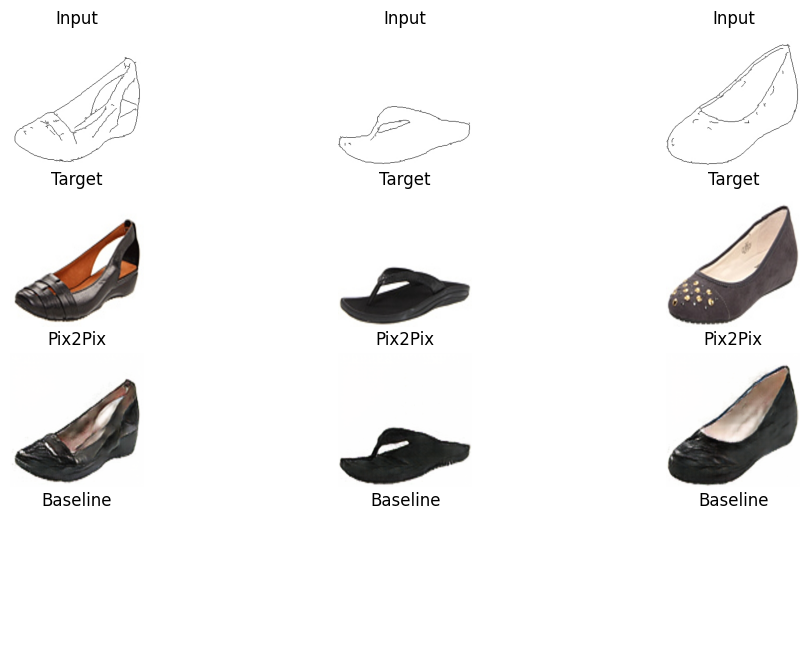

In [12]:
def show_results():
    x, y = next(iter(test_loader))
    x, y = x.to(device), y.to(device)

    with torch.no_grad():
        pix2pix_out = G(x)
        baseline_out = baseline(x)

    x = x.cpu()
    y = y.cpu()
    pix2pix_out = pix2pix_out.cpu()
    baseline_out = baseline_out.cpu()

    plt.figure(figsize=(12, 8))
    for i in range(3):
        plt.subplot(4, 3, i+1)
        plt.title("Input")
        plt.imshow((x[i].permute(1,2,0)+1)/2)
        plt.axis("off")

        plt.subplot(4, 3, i+4)
        plt.title("Target")
        plt.imshow((y[i].permute(1,2,0)+1)/2)
        plt.axis("off")

        plt.subplot(4, 3, i+7)
        plt.title("Pix2Pix")
        plt.imshow((pix2pix_out[i].permute(1,2,0)+1)/2)
        plt.axis("off")

        plt.subplot(4, 3, i+10)
        plt.title("Baseline")
        plt.imshow((baseline_out[i].permute(1,2,0)+1)/2)
        plt.axis("off")

    plt.show()

show_results()
